# LSLGA Groups

The purpose of this notebook is to build a group catalog from the parent sample of large galaxies.  Galaxies near one another (projected on the sky) must be analyzed at the same time, so we use a simple friends-of-friends algorithm to generate the group catalog.

## Preliminaries

Import the libraries we need, define the I/O path, and specify the desired linking length (in arcminutes) and the minimum D(25) of the galaxy sample.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import astropy.units as u
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord

In [3]:
import fitsio
from pydl.pydlutils.spheregroup import spheregroup

In [4]:
%matplotlib inline

In [5]:
LSLGAdir = os.getenv('LSLGA_DIR')

In [6]:
mindiameter = 0.75 # [arcmin]
linking_length = 3.0 # [arcmin]

## Read the parent HyperLeda catalog.

We immediately throw out objects with objtype='g' in Hyperleda, which are "probably extended" and many (most? all?) have incorrect D(25) diameters.  We also toss out objects with D(25)>2.5 arcmin and B>16, which are also probably incorrect.

In [7]:
suffix = '0.05'

In [8]:
ledafile = os.path.join(LSLGAdir, 'sample', 'leda-logd25-{}.fits'.format(suffix))
leda = Table.read(ledafile)

keep = (np.char.strip(leda['OBJTYPE']) != 'g') * (leda['D25'] / 60 > mindiameter)
leda = leda[keep]

keep = ['SDSS' not in gg and '2MAS' not in gg for gg in leda['GALAXY']]
#keep = np.logical_and( (np.char.strip(leda['OBJTYPE']) != 'g'), ~((leda['D25'] / 60 > 2.5) * (leda['BMAG'] > 16)) )
leda = leda[keep]
leda

GALAXY,PGC,RA,DEC,TYPE,OBJTYPE,MULTIPLE,D25,BA,PA,BMAG,IMAG,VHELIO
str28,str10,float64,float64,str4,str2,str1,float32,float32,float32,float32,float32,float32
PGC130936,PGC0130936,0.0036,-40.90328,E,G,,54.7206,0.501187,20.0,15.58,13.59,14911.0
UGC12889,PGC0000002,0.00705,47.2745,Sb,G,,111.725,0.630957,163.5,14.13,-999.0,5017.0
PGC000004,PGC0000004,0.0144,23.08762,Sc,G,,51.0683,0.218776,63.2,16.88,15.19,4461.0
UGC12890,PGC0000014,0.02925,8.27911,E,G,,92.929,0.537032,9.5,15.78,-999.0,11602.0
PGC000012,PGC0000012,0.036,-6.37392,Sa,G,,84.7523,0.218776,168.2,14.84,-999.0,6546.0
IC5370,PGC0000005,0.0381,32.73839,S0-a,G,,46.5748,0.912011,-999.0,14.89,-999.0,10445.0
PGC000016,PGC0000016,0.0471,-5.15877,S0-a,G,,55.9953,0.489779,38.5,15.1,-999.0,5666.0
PGC100703,PGC0100703,0.04965,-66.51272,S0,G,,47.6597,0.870964,86.7,15.28,13.25,21754.0
PGC000020,PGC0000020,0.05325,1.12022,IAB,G,,52.2578,0.645654,132.5,15.18,14.06,7395.0


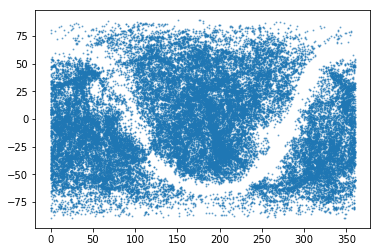

In [9]:
fig, ax = plt.subplots()
ax.scatter(leda['RA'], leda['DEC'], s=1, alpha=0.5)

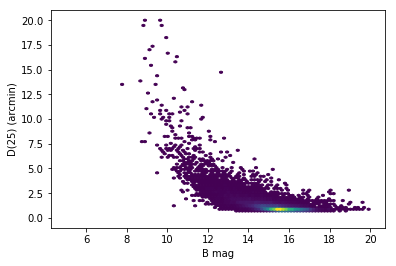

In [10]:
fig, ax = plt.subplots()
ax.hexbin(leda['BMAG'], leda['D25'] / 60, extent=(5, 20, 0, 20),
          mincnt=1)
ax.set_xlabel('B mag')
ax.set_ylabel('D(25) (arcmin)')

In [11]:
if False:
    these = (leda['RA'] > 200) * (leda['RA'] < 210) * (leda['DEC'] > 5) * (leda['DEC'] < 10.0)
    leda = leda[these]
    print(np.sum(these))

## Run FoF with spheregroup

Identify groups using a simple angular linking length.  Then construct a catalog of group properties.

In [12]:
%time grp, mult, frst, nxt = spheregroup(leda['RA'], leda['DEC'], linking_length / 60.0)

CPU times: user 26.8 s, sys: 535 ms, total: 27.3 s
Wall time: 28.3 s


In [13]:
npergrp, _ = np.histogram(grp, bins=len(grp), range=(0, len(grp)))
nbiggrp = np.sum(npergrp > 1).astype('int')
nsmallgrp = np.sum(npergrp == 1).astype('int')
ngrp = nbiggrp + nsmallgrp

In [14]:
print('Found {} total groups, including:'.format(ngrp))
print('  {} groups with 1 member'.format(nsmallgrp))
print('  {} groups with 2-5 members'.format(np.sum( (npergrp > 1)*(npergrp <= 5) ).astype('int')))
print('  {} groups with 5-10 members'.format(np.sum( (npergrp > 5)*(npergrp <= 10) ).astype('int')))
print('  {} groups with >10 members'.format(np.sum( (npergrp > 10) ).astype('int')))

Found 48858 total groups, including:
  46964 groups with 1 member
  1892 groups with 2-5 members
  2 groups with 5-10 members
  0 groups with >10 members


## Populate the output group catalog

Also add GROUPID to parent catalog to make it easier to cross-reference the two tables.  D25MAX and D25MIN are the maximum and minimum D(25) diameters of the galaxies in the group.

In [15]:
groupcat = Table()
groupcat.add_column(Column(name='GROUPID', dtype='i4', length=ngrp, data=np.arange(ngrp))) # unique ID number
groupcat.add_column(Column(name='GALAXY', dtype='S500', length=ngrp))
groupcat.add_column(Column(name='NMEMBERS', dtype='i4', length=ngrp))
groupcat.add_column(Column(name='RA', dtype='f8', length=ngrp))  # average RA
groupcat.add_column(Column(name='DEC', dtype='f8', length=ngrp)) # average Dec
groupcat.add_column(Column(name='DIAMETER', dtype='f4', length=ngrp))
groupcat.add_column(Column(name='D25MAX', dtype='f4', length=ngrp))
groupcat.add_column(Column(name='D25MIN', dtype='f4', length=ngrp))

In [16]:
leda_groupid = leda.copy()
leda_groupid.add_column(Column(name='GROUPID', dtype='i4', length=len(leda)))
leda_groupid

GALAXY,PGC,RA,DEC,TYPE,OBJTYPE,MULTIPLE,D25,BA,PA,BMAG,IMAG,VHELIO,GROUPID
str28,str10,float64,float64,str4,str2,str1,float32,float32,float32,float32,float32,float32,int32
PGC130936,PGC0130936,0.0036,-40.90328,E,G,,54.7206,0.501187,20.0,15.58,13.59,14911.0,0
UGC12889,PGC0000002,0.00705,47.2745,Sb,G,,111.725,0.630957,163.5,14.13,-999.0,5017.0,0
PGC000004,PGC0000004,0.0144,23.08762,Sc,G,,51.0683,0.218776,63.2,16.88,15.19,4461.0,0
UGC12890,PGC0000014,0.02925,8.27911,E,G,,92.929,0.537032,9.5,15.78,-999.0,11602.0,0
PGC000012,PGC0000012,0.036,-6.37392,Sa,G,,84.7523,0.218776,168.2,14.84,-999.0,6546.0,0
IC5370,PGC0000005,0.0381,32.73839,S0-a,G,,46.5748,0.912011,-999.0,14.89,-999.0,10445.0,0
PGC000016,PGC0000016,0.0471,-5.15877,S0-a,G,,55.9953,0.489779,38.5,15.1,-999.0,5666.0,0
PGC100703,PGC0100703,0.04965,-66.51272,S0,G,,47.6597,0.870964,86.7,15.28,13.25,21754.0,0
PGC000020,PGC0000020,0.05325,1.12022,IAB,G,,52.2578,0.645654,132.5,15.18,14.06,7395.0,0


#### Groups with one member--

In [17]:
smallindx = np.arange(nsmallgrp)

In [18]:
ledaindx = np.where(npergrp == 1)[0]
groupcat['RA'][smallindx] = leda['RA'][ledaindx]
groupcat['DEC'][smallindx] = leda['DEC'][ledaindx]
groupcat['NMEMBERS'][smallindx] = 1
groupcat['GALAXY'][smallindx] = np.char.strip(leda['GALAXY'][ledaindx])
groupcat['DIAMETER'][smallindx] = leda['D25'][ledaindx] # [arcsec]
groupcat['D25MAX'][smallindx] = leda['D25'][ledaindx]   # [arcsec]
groupcat['D25MIN'][smallindx] = leda['D25'][ledaindx]   # [arcsec]

leda_groupid['GROUPID'][ledaindx] = groupcat['GROUPID'][smallindx]

#### Groups with more than one member--

In [19]:
bigindx = np.arange(nbiggrp) + nsmallgrp

In [20]:
coord = SkyCoord(ra=leda['RA']*u.degree, dec=leda['DEC']*u.degree)

In [21]:
def biggroups():
    for grpindx, indx in zip(bigindx, np.where(npergrp > 1)[0]):

        ledaindx = np.where(grp == indx)[0]
        _ra, _dec = np.mean(leda['RA'][ledaindx]), np.mean(leda['DEC'][ledaindx])
        d25min, d25max = np.min(leda['D25'][ledaindx]), np.max(leda['D25'][ledaindx])
    
        groupcat['RA'][grpindx] = _ra
        groupcat['DEC'][grpindx] = _dec
        groupcat['D25MAX'][grpindx] = d25max
        groupcat['D25MIN'][grpindx] = d25min

        groupcat['NMEMBERS'][grpindx] = len(ledaindx)
        groupcat['GALAXY'][grpindx] = ','.join(np.char.strip(leda['GALAXY'][ledaindx]))
        leda_groupid['GROUPID'][ledaindx] = groupcat['GROUPID'][grpindx]

        # Get the distance of each object from the group center.
        cc = SkyCoord(ra=_ra*u.degree, dec=_dec*u.degree)
        diameter = 2 * coord[ledaindx].separation(cc).arcsec.max()

        groupcat['DIAMETER'][grpindx] = np.max( (diameter*1.02, d25max) )

In [22]:
%time biggroups()

CPU times: user 12.2 s, sys: 157 ms, total: 12.3 s
Wall time: 12.4 s


In [23]:
leda_groupid

GALAXY,PGC,RA,DEC,TYPE,OBJTYPE,MULTIPLE,D25,BA,PA,BMAG,IMAG,VHELIO,GROUPID
str28,str10,float64,float64,str4,str2,str1,float32,float32,float32,float32,float32,float32,int32
PGC130936,PGC0130936,0.0036,-40.90328,E,G,,54.7206,0.501187,20.0,15.58,13.59,14911.0,0
UGC12889,PGC0000002,0.00705,47.2745,Sb,G,,111.725,0.630957,163.5,14.13,-999.0,5017.0,1
PGC000004,PGC0000004,0.0144,23.08762,Sc,G,,51.0683,0.218776,63.2,16.88,15.19,4461.0,2
UGC12890,PGC0000014,0.02925,8.27911,E,G,,92.929,0.537032,9.5,15.78,-999.0,11602.0,3
PGC000012,PGC0000012,0.036,-6.37392,Sa,G,,84.7523,0.218776,168.2,14.84,-999.0,6546.0,4
IC5370,PGC0000005,0.0381,32.73839,S0-a,G,,46.5748,0.912011,-999.0,14.89,-999.0,10445.0,5
PGC000016,PGC0000016,0.0471,-5.15877,S0-a,G,,55.9953,0.489779,38.5,15.1,-999.0,5666.0,6
PGC100703,PGC0100703,0.04965,-66.51272,S0,G,,47.6597,0.870964,86.7,15.28,13.25,21754.0,7
PGC000020,PGC0000020,0.05325,1.12022,IAB,G,,52.2578,0.645654,132.5,15.18,14.06,7395.0,8


In [24]:
groupcat

GROUPID,GALAXY,NMEMBERS,RA,DEC,DIAMETER,D25MAX,D25MIN
int32,bytes500,int32,float64,float64,float32,float32,float32
0,PGC130936,1,0.0036,-40.90328,54.7206,54.7206,54.7206
1,UGC12889,1,0.00705,47.2745,111.725,111.725,111.725
2,PGC000004,1,0.0144,23.08762,51.0683,51.0683,51.0683
3,UGC12890,1,0.02925,8.27911,92.929,92.929,92.929
4,PGC000012,1,0.036,-6.37392,84.7523,84.7523,84.7523
5,IC5370,1,0.0381,32.73839,46.5748,46.5748,46.5748
6,PGC000016,1,0.0471,-5.15877,55.9953,55.9953,55.9953
7,PGC100703,1,0.04965,-66.51272,47.6597,47.6597,47.6597
8,PGC000020,1,0.05325,1.12022,52.2578,52.2578,52.2578


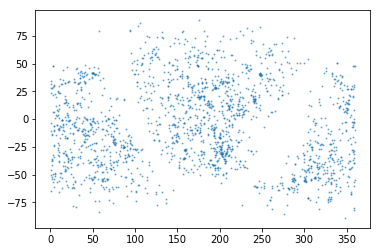

In [25]:
ww = np.where(groupcat['NMEMBERS'] >= 2)[0]
fig, ax = plt.subplots()
ax.scatter(groupcat['RA'][ww], groupcat['DEC'][ww], s=1, alpha=0.5)

In [26]:
groupfile = os.path.join(LSLGAdir, 'sample', 'leda-logd25-{}-groupcat.fits'.format(suffix))
print('Writing {}'.format(groupfile))
groupcat.write(groupfile, overwrite=True)

Writing /Users/ioannis/research/projects/LSLGA/sample/leda-logd25-0.05-groupcat.fits


In [27]:
ledafile_groupid = os.path.join(LSLGAdir, 'sample', 'leda-logd25-{}-groupid.fits'.format(suffix))
print('Writing {}'.format(ledafile_groupid))
leda_groupid.write(ledafile_groupid, overwrite=True)

Writing /Users/ioannis/research/projects/LSLGA/sample/leda-logd25-0.05-groupid.fits
